In [1]:
import numpy as np
import tensorflow as tf
import os
import struct
import matplotlib.pyplot as plt
from layers.CapsLayer import CapsLayer
from layers.ConvCapsLayer import ConvCapsLayer
from layers.ConvLayer import ConvLayer
from layers.DenseLayer import DenseLayer

/home/luke/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("./train-images.idx3-ubyte")
        self._training_labels = self._load_binaries("./train-labels.idx1-ubyte")
        self._test_data = self._load_binaries("./t10k-images.idx3-ubyte")
        self._test_labels = self._load_binaries("./t10k-labels.idx1-ubyte")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

In [3]:
#STORING THE DATA
mnist_data = MNIST('/home/luke/data/mnist/')

In [4]:
#HYPERPARAMETERS

#TRAINING PARAMS
batch_size = 1


In [5]:
def mask_and_flatten_digit_caps(digit_caps, labels):
    
    labels = tf.one_hot(labels, depth=10)
    print(labels.get_shape())
    labels = tf.expand_dims(labels, axis=-1)
    print(labels.get_shape())
    labels = tf.tile(labels, [1,1,16])
    print(labels.get_shape())
    masked_digit_caps = digit_caps * labels
    print(masked_digit_caps.get_shape())
    masked_and_flat = tf.reshape(masked_digit_caps, shape=[batch_size,10*16])
    print(masked_and_flat)
    return tf.reshape(masked_digit_caps, shape=[batch_size,10*16]) 

def calculate_loss_accuracy(digit_caps, labels):
    
    length_digit_caps = tf.norm(digit_caps, axis = 2)
    labels_one_hot = tf.one_hot(labels, depth=10)
    
   
    plus_loss =  labels_one_hot * tf.nn.relu(0.9 - length_digit_caps)
    minus_loss = 0.5 * (1 - labels_one_hot) * \
                        tf.nn.relu(length_digit_caps - 0.1)
    
    loss = tf.reduce_sum(plus_loss + minus_loss, axis=-1)
    loss = tf.reduce_mean(loss)
    
    correct_prediction = tf.equal(tf.argmax(length_digit_caps, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return loss, accuracy


def calculate_reconstruction_loss(reconstructions, images):
    
    images = images/255.0
    images_flatten = tf.reshape(images, shape=[batch_size, 784])
    squared_error = tf.squared_difference(reconstructions, images_flatten)
    sse = tf.reduce_sum(squared_error, axis=-1)
    
    return 0.0005 * tf.reduce_mean(sse)
    

In [6]:
#DESCIRBING THE DATAFLOW GRAPH

tf.reset_default_graph()

# define the placeholders
images = tf.placeholder(dtype=tf.float32, shape=[batch_size, 28, 28])
images_exp = tf.expand_dims(images, axis=-1)
labels = tf.placeholder(dtype=tf.int64, shape=[batch_size])




with tf.variable_scope('ReLU_Conv1'):
    conv_layer = ConvLayer(
                    kernel_size = 9,
                    stride = 1,
                    padding = 'VALID',
                    channels = 256,
                    activation_function = 'ReLU' 
                 )
    conv = conv_layer(images_exp)

    
with tf.variable_scope('Primary_Caps'):
    primary_caps_layer = ConvCapsLayer(
                            kernel_size = 9,
                            stride = 2,
                            padding = 'VALID',
                            dimension = 8,
                            channels = 32,
                        )
    primary_caps = primary_caps_layer(conv)

    
with tf.variable_scope('Digit_Caps'):
    digit_caps_layer = CapsLayer(
                            count1 = 6*6*32,
                            dim1 = 8,
                            count2 = 10,
                            dim2 = 16,
                            rout_iter = 3
                        )
    digit_caps = digit_caps_layer(primary_caps)




with tf.variable_scope('Loss'):
    loss, accuracy = calculate_loss_accuracy(digit_caps, labels)

#RECONSTRUCTOR

# introduce a placeholder to feed in other values
digit_caps_placeholder = tf.placeholder_with_default(digit_caps, shape=[None, 10, 16])


# flatten and mask the digit capsules
digit_caps_flat = mask_and_flatten_digit_caps(digit_caps_placeholder,
                                                labels
                                                )




with tf.variable_scope('Dense1'):
    dense_1_layer = DenseLayer(
                        n_out = 512,
                        activation_function = 'ReLU'
                    )
    dense_1 = dense_1_layer(digit_caps_flat)
    

with tf.variable_scope('Dense2'):
    dense_2_layer = DenseLayer(
                        n_out = 1024,
                        activation_function = 'ReLU'
                    )
    dense_2 = dense_2_layer(dense_1)

    
with tf.variable_scope('Dense3'):
    dense_3_layer = DenseLayer(
                        n_out = 28*28,
                        activation_function = 'Sigmoid'
                    )
    dense_3 = dense_3_layer(dense_2)
    reconstructions = tf.reshape(dense_3, shape=[batch_size, 28, 28])
    
    
with tf.variable_scope('Reconstruction_Loss'):
    reconstruction_loss = calculate_reconstruction_loss(dense_3, images)
    

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(loss+reconstruction_loss)
    
    


#SUMMARIES
tf.summary.scalar('loss', loss)

merged_summaries = tf.summary.merge_all()

(1, 10)
(1, 10, 1)
(1, 10, 16)
(?, 10, 16)
Tensor("Reshape:0", shape=(1, 160), dtype=float32)


INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
model restored
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
model restored
Dimension 1


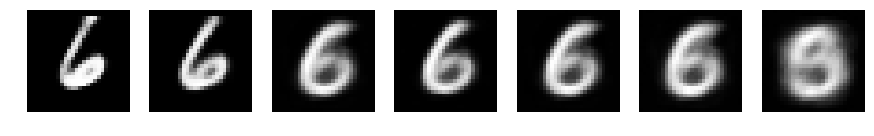

Dimension 2


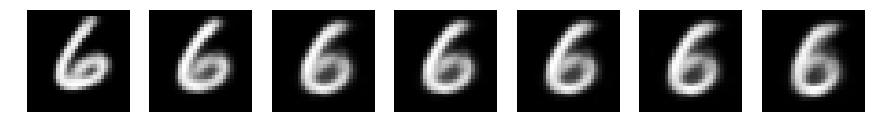

Dimension 3


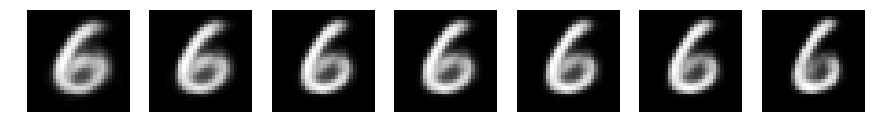

Dimension 4


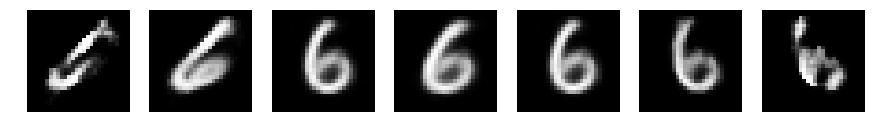

Dimension 5


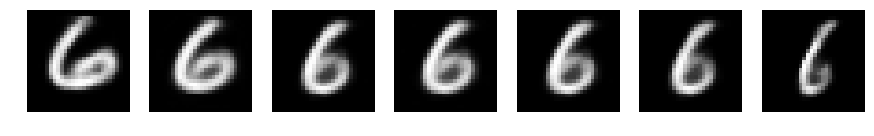

Dimension 6


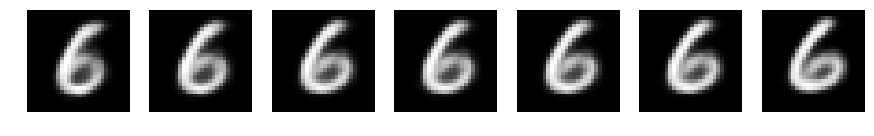

Dimension 7


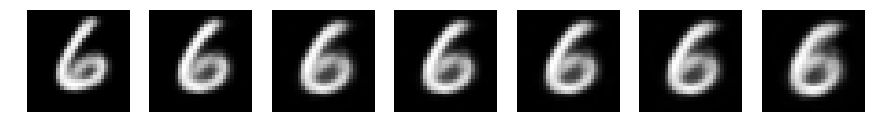

Dimension 8


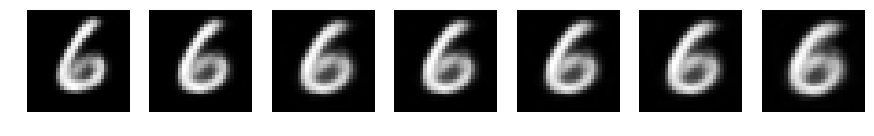

Dimension 9


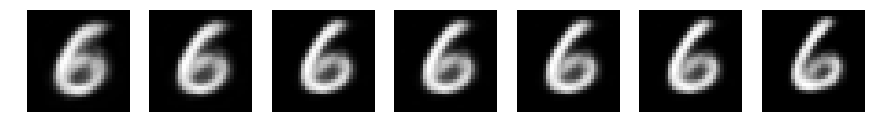

Dimension 10


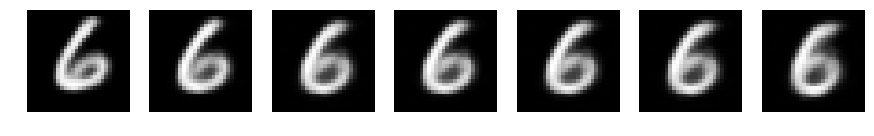

Dimension 11


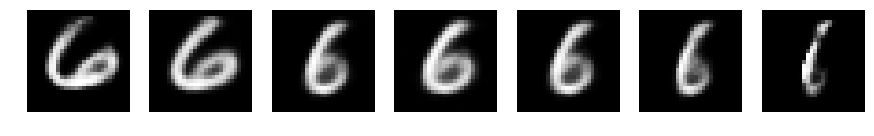

Dimension 12


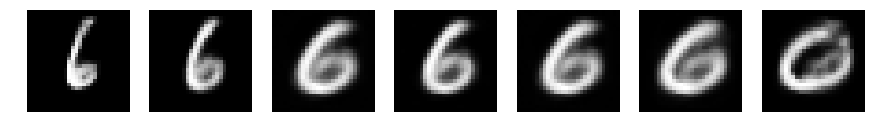

Dimension 13


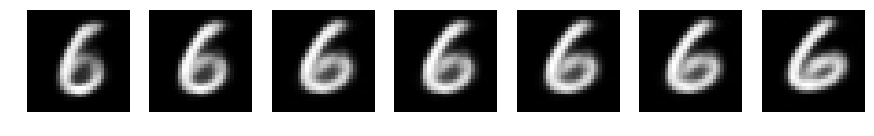

Dimension 14


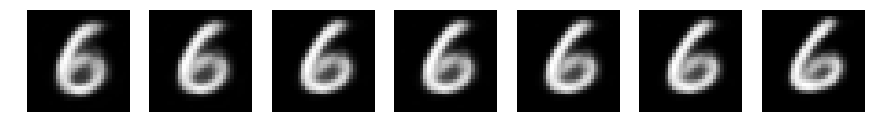

Dimension 15


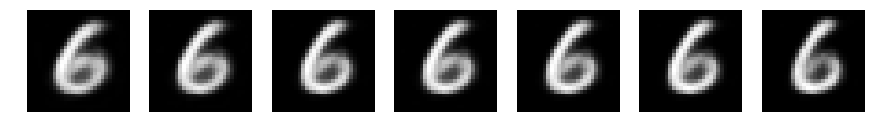

Dimension 16


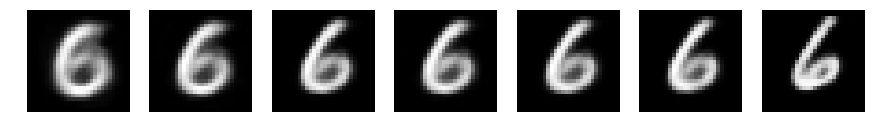

In [12]:
saver = tf.train.Saver()



with tf.Session() as sess:
    step = 0
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./tmp/model.ckpt")
    print('model restored')
    batch_generator = mnist_data.get_training_batch(1)

    
    
    for x, y in batch_generator:
        if step == 0:
            dcs = sess.run([digit_caps],feed_dict = {images: x,
                                                     labels: y})
            #train_writer.add_summary(_summaries, step)
            step += 1
            img = x
            lbl = y
            '''
            # for validation plot a image and its reconstruction
            fig = plt.figure(figsize = (9,5))
            fig.add_subplot(1,2,1)
            plt.imshow(x[0], cmap='gray')
            plt.title('Image')
            fig.add_subplot(1,2,2)
            plt.imshow(_rec[0], cmap='gray')
            plt.title('Reconstruction')
            plt.show()
            '''
        else:
            break
        
    

saver = tf.train.Saver()



iterat = pertubate(dcs[0], lbl[0])


with tf.Session() as sess:
    step = 0
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./tmp/model.ckpt")
    print('model restored')
    #batch_generator = mnist_data.get_training_batch(1)
    
    iterat = [iterat[i:i+7] for i in range(0, len(iterat), 7)] 
    
    for j,dim in enumerate(iterat):
        print('Dimension {}'.format(j+1))
        fig = plt.figure(figsize = (15,10))
        
        for i, delta in enumerate(dim):
            
            _rec = sess.run([reconstructions],feed_dict = {digit_caps_placeholder:delta,
                                                                    labels: lbl})
            fig.add_subplot(1,7,i+1)
            plt.imshow(_rec[0][0], cmap='gray')
            plt.axis('off')
            
            
        plt.show()
        
        


In [9]:
# pertubate the dimensions

def pertubate(capsules, label):
    
    pertubated_caps = []
    cs = np.copy(capsules)
    for dim in range(16):
        for delta in [-0.25,-0.1,0.05,0,0.05,0.1,0.25]:
        
            d = np.copy(cs)
            d[0][label][dim] += delta
            pertubated_caps.append(d)
            
    return pertubated_caps
            
            
        